In [46]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
header = {'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.119 Safari/537.36'}

In [47]:
def getDownload(url, param=None, retries=3):
    resp = None
    try:
        resp = requests.get(url, params=param, headers=header)
        resp.raise_for_status()
    except requests.exceptions.HTTPError as e:
        if 500 <= resp.status_code < 600 and retries > 0:
            print('Retries : {0}'.format(retries))
            return getDownload(url, param, retries - 1)
        else:
            print(resp.status_code)
            print(resp.reason)
            print(resp.request.headers)
    return resp

In [49]:
url = 'https://movie.naver.com/movie/point/af/list.nhn'
params = {'page':1}

html = getDownload(url)
dom = BeautifulSoup(html.text, 'html.parser')

In [51]:
result = list()
for page in range(1, 1000+1):
    params['page'] = page
    html = getDownload(url, params)
    dom = BeautifulSoup(html.text, 'html.parser')

    title = [tag.text.split('\n')[1] for tag in dom.select('table.list_netizen td.title')]
    content = [tag.text.split('\n')[2] for tag in dom.select('table.list_netizen td.title')]
    point = [tag.text for tag in dom.select('table.list_netizen td.point')]

    pd_title = pd.DataFrame(title, columns=['제목'])
    pd_content = pd.DataFrame(content, columns=['리뷰'])
    pd_point = pd.DataFrame(point, columns=['평점'])
    pd_result = pd.concat([pd_title, pd_content, pd_point], axis=1)
    
    result.append(pd_result)
    
excel = pd.concat(result)
excel.to_csv('./NaverMovieReview/movie.csv', index=False)

In [55]:
data = pd.read_csv('./NaverMovieReview/movie.csv')
data.head()

,제목,리뷰,평점
0,어벤져스: 엔드게임,세상에서 가장 깔끔한 정리....,10
1,어벤져스: 엔드게임,어벤져스 앤드게임긴 시간동안 고대하며 기다린 만큼어벤져스 시리즈의 마지막이라서 그런...,10
2,어벤져스: 엔드게임,진짜 엔드게임이구나....,10
3,에이리언: 커버넌트,역대 에이리언 시리즈랑 분위기가 다름,10
4,어벤져스: 엔드게임,어벤져스의 마지막.. 너무. 아쉬워요 ㅠㅠ너무 재밌었고 더 이어졌으면 하는 바람만...,10


In [56]:
data.count()

제목    10000
리뷰    10000
평점    10000
dtype: int64

In [57]:
data.groupby(["평점"]).count()

,제목,리뷰
평점,,
1,421,421
2,178,178
3,31,31
4,106,106
5,92,92
6,320,320
7,173,173
8,696,696
9,388,388


In [58]:
upperBound = 7
lowerBound = 3

data = data[data["평점"] < 10]
positive = data[data["평점"] > upperBound]
negative = data[data["평점"] < lowerBound]

In [59]:
len(positive), len(negative)

(1084, 599)

In [60]:
from collections import Counter, defaultdict
from konlpy.tag import Komoran

# DTM만들기
positiveDTM = defaultdict(Counter)
# Positive 1 => {"형태소/품사" = 횟수, "형태소/품사" = 횟수, "형태소/품사" = 횟수, ...}
# Negative 1 => {"형태소/품사" = 횟수, "형태소/품사" = 횟수, "형태소/품사" = 횟수, ...}
negativeDTM = defaultdict(Counter)

ma = Komoran()

for i, review in enumerate(positive["리뷰"]):
    posList = ma.pos(review) # => [[형태소, 품사], ]
    
    for term in posList: # => [형태소, 품사]
        if len(term[0]) > 1:
            positiveDTM[i]["/".join(term)] += 1 # => "형태소/품사"
            
for i, review in enumerate(negative["리뷰"]):
    posList = ma.pos(review)
    
    for term in posList:
        if len(term[0]) > 1:
            negativeDTM[i]["/".join(term)] += 1

In [61]:
# TDM만들기
positiveTDM = defaultdict(Counter)
negativeTDM = defaultdict(Counter)

for i, termList in positiveDTM.items():
    for term, freq in termList.items():
        positiveTDM[term][i] = freq

for i, termList in negativeDTM.items():
    for term, freq in termList.items():
        negativeTDM[term][i] = freq

In [62]:
positiveLexicon = list(set(positiveTDM.keys()))
negativeLexicon = list(set(negativeTDM.keys()))

positiveDocuments = list(positiveDTM.keys())
negativeDocuments = list(negativeDTM.keys())

In [64]:
from collections import defaultdict, Counter # defaultdict 두개 중첩하는 대신 Counter 사용. 
# Counter는 defaultdict처럼 돌아가지만 빈도별로 알아서 구성해줌(sorting 불필요). 

positivePOS = defaultdict(Counter)
negativePOS = defaultdict(Counter)

for term in positiveLexicon:
    tokens = term.split("/")
    # "형태소/품사" -> tokens[0]:형태소(ex. 어/벤/저/스), tokens[1]:품사
    # TDM[term] => 어느 문서에서 몇 번, 
    
    positivePOS[tokens[-1]]["".join(tokens[0:-1])] += sum(positiveTDM[term].values())
    # 명사 -> 단어1:positive 내 전체 등장횟수, 단어2:, 단어3:, ...
    # '어/벤/져/스'같은 경우에 대해서도 잘 작동하도록 하기 위함
    
for term in negativeLexicon:
    tokens = term.split("/")
    
    negativePOS[tokens[-1]][tokens[0]] += sum(negativeTDM[term].values())

In [65]:
positivePOS.keys()

dict_keys(['NNP', 'NA', 'VV', 'XR', 'NNG', 'SL', 'EF', 'MAG', 'MM', 'NNB', 'NP', 'VA', 'EC', 'SN', 'JKB', 'XSV', 'MAJ', 'VX', 'XSN', 'ETM', 'IC', 'JX', 'EP', 'NR', 'SE', 'JKS', 'VCN', 'JC', 'XSA'])

In [66]:
positivePOS["NNG"].most_common()[:20] # Counter모듈 덕분에 그냥 :20을 통해 상위 20개 출력가능

[('영화', 193),
 ('마지막', 78),
 ('생각', 70),
 ('기대', 67),
 ('마무리', 47),
 ('느낌', 36),
 ('장면', 35),
 ('시간', 34),
 ('감동', 33),
 ('내용', 32),
 ('인피', 29),
 ('사람', 29),
 ('초반', 26),
 ('마음', 23),
 ('부분', 23),
 ('엄마', 22),
 ('이해', 22),
 ('시작', 22),
 ('최고', 22),
 ('중간', 21)]

In [67]:
negativePOS["NNG"].most_common()[:20]

[('영화', 161),
 ('평점', 43),
 ('시간', 29),
 ('생각', 20),
 ('사람', 20),
 ('내용', 18),
 ('최악', 18),
 ('여자', 15),
 ('기대', 15),
 ('개연', 14),
 ('수준', 14),
 ('처음', 12),
 ('마지막', 11),
 ('감동', 11),
 ('감독', 10),
 ('제일', 9),
 ('진짜', 9),
 ('이상', 9),
 ('이야기', 8),
 ('이해', 7)]

In [68]:
Komoran().tagset

{'EC': '연결 어미',
 'EF': '종결 어미',
 'EP': '선어말어미',
 'ETM': '관형형 전성 어미',
 'ETN': '명사형 전성 어미',
 'IC': '감탄사',
 'JC': '접속 조사',
 'JKB': '부사격 조사',
 'JKC': '보격 조사',
 'JKG': '관형격 조사',
 'JKO': '목적격 조사',
 'JKQ': '인용격 조사',
 'JKS': '주격 조사',
 'JKV': '호격 조사',
 'JX': '보조사',
 'MAG': '일반 부사',
 'MAJ': '접속 부사',
 'MM': '관형사',
 'NA': '분석불능범주',
 'NF': '명사추정범주',
 'NNB': '의존 명사',
 'NNG': '일반 명사',
 'NNP': '고유 명사',
 'NP': '대명사',
 'NR': '수사',
 'NV': '용언추정범주',
 'SE': '줄임표',
 'SF': '마침표, 물음표, 느낌표',
 'SH': '한자',
 'SL': '외국어',
 'SN': '숫자',
 'SO': '붙임표(물결,숨김,빠짐)',
 'SP': '쉼표,가운뎃점,콜론,빗금',
 'SS': '따옴표,괄호표,줄표',
 'SW': '기타기호 (논리수학기호,화폐기호)',
 'VA': '형용사',
 'VCN': '부정 지정사',
 'VCP': '긍정 지정사',
 'VV': '동사',
 'VX': '보조 용언',
 'XPN': '체언 접두사',
 'XR': '어근',
 'XSA': '형용사 파생 접미사',
 'XSN': '명사파생 접미사',
 'XSV': '동사 파생 접미사'}

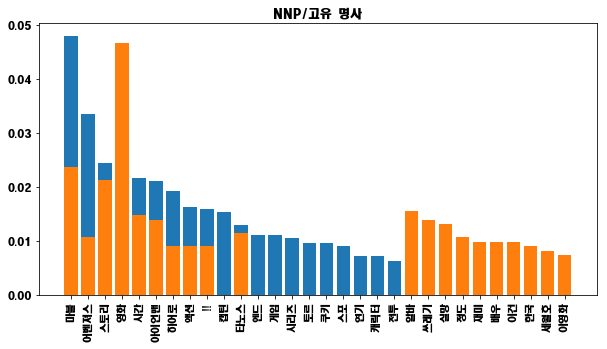

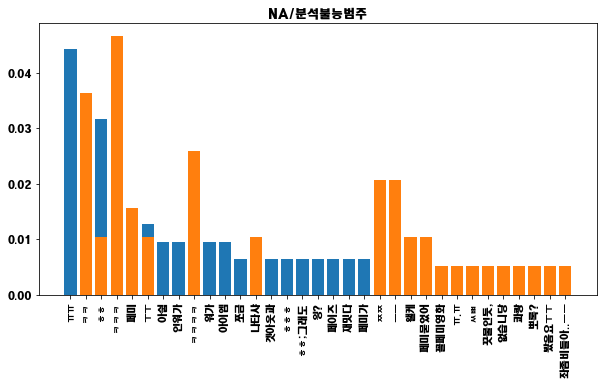

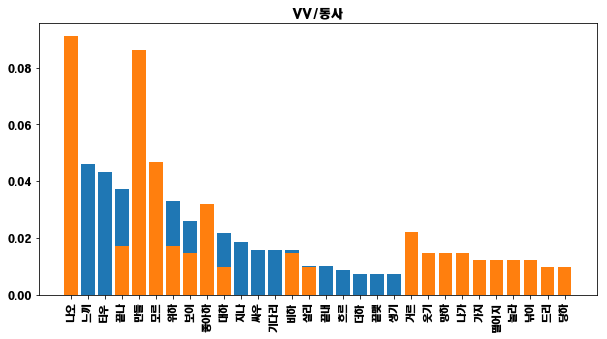

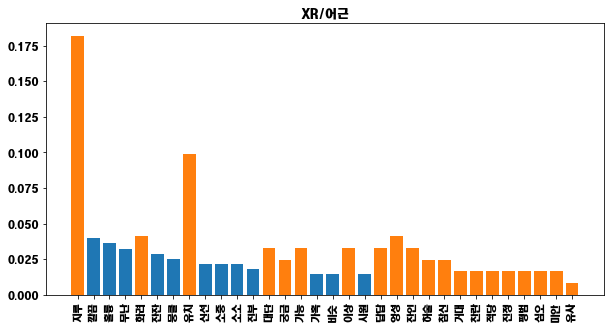

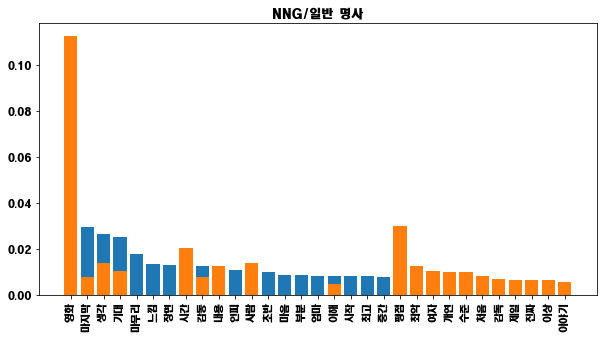

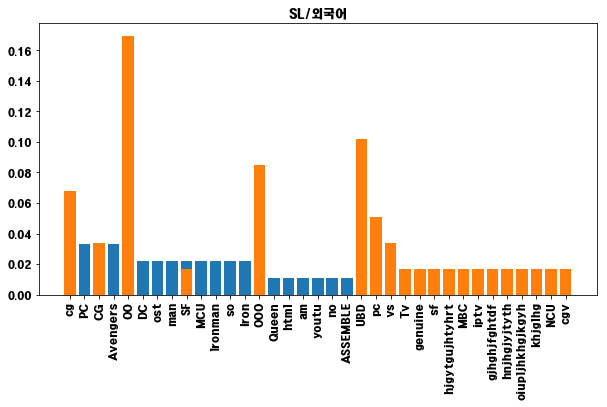

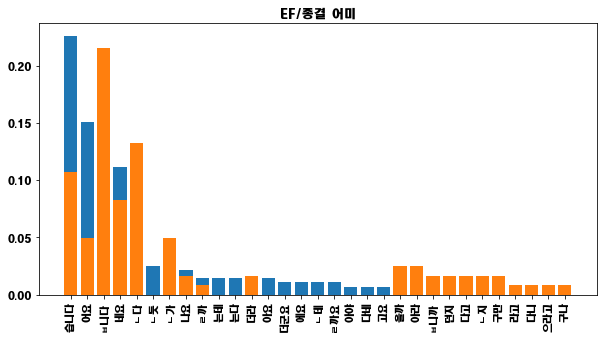

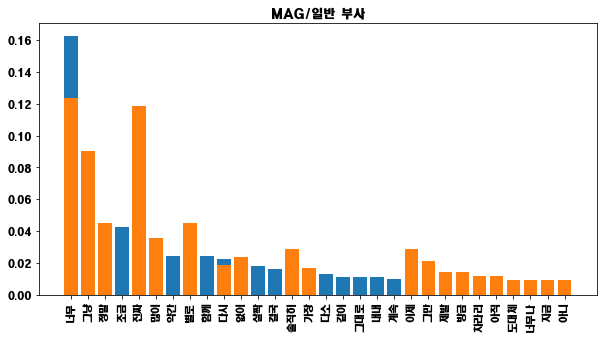

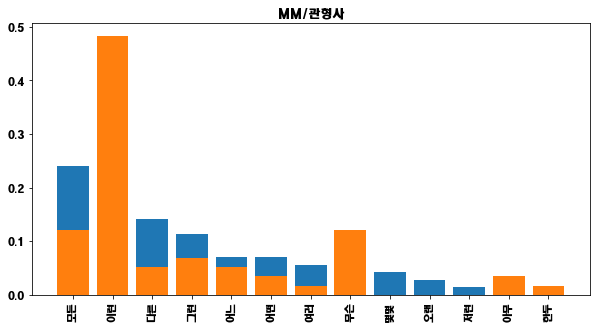

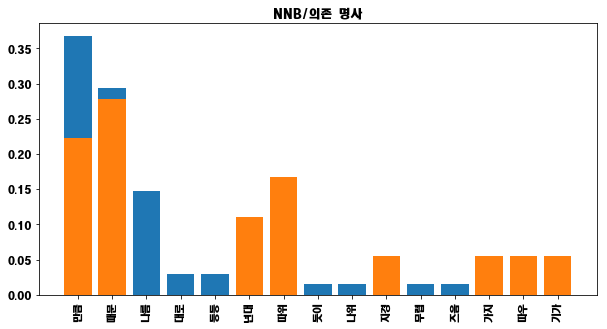

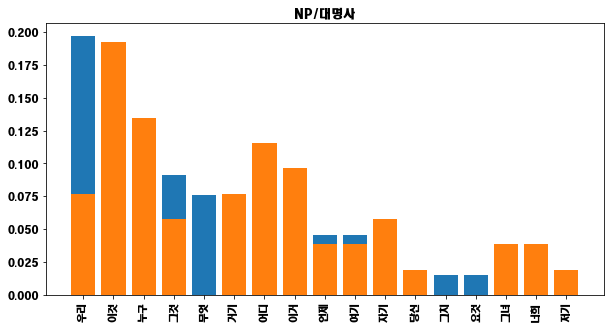

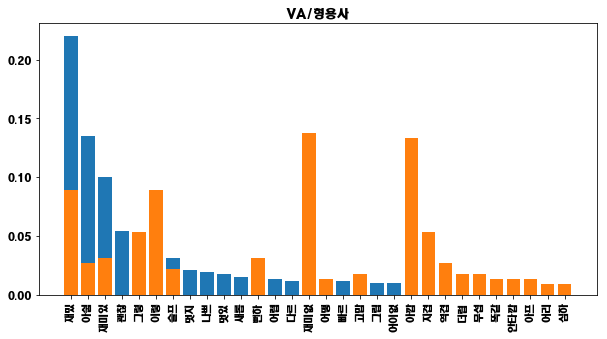

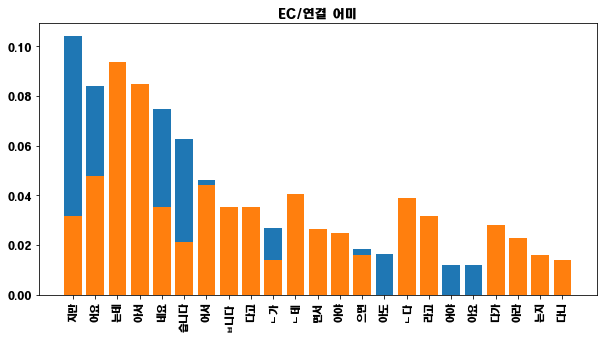

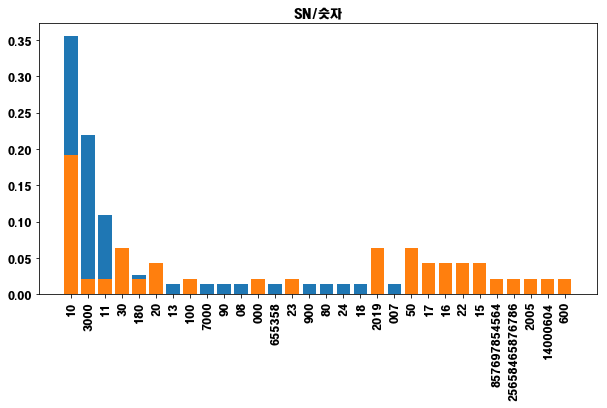

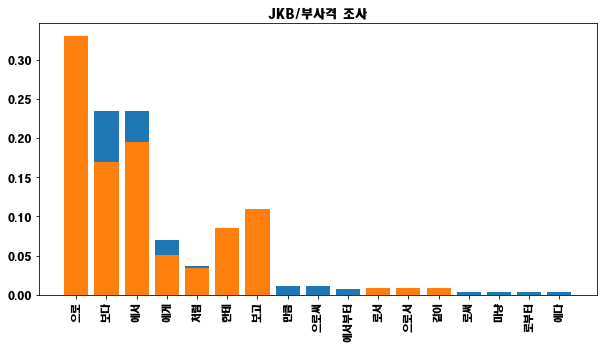

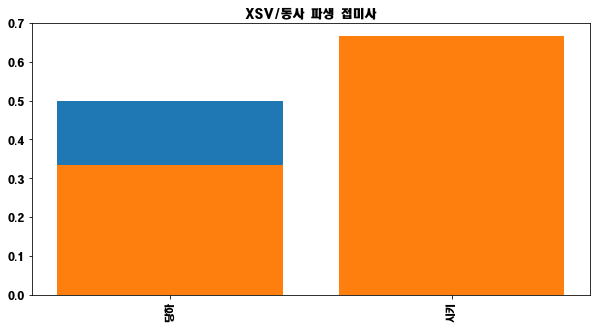

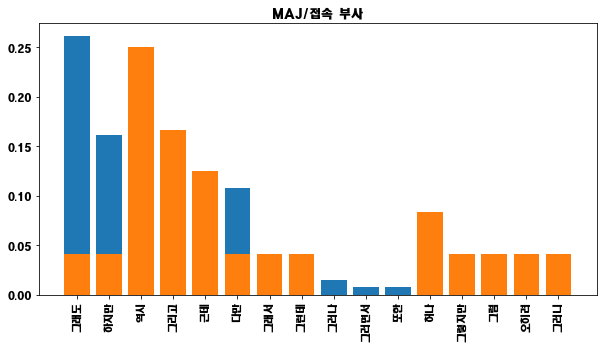

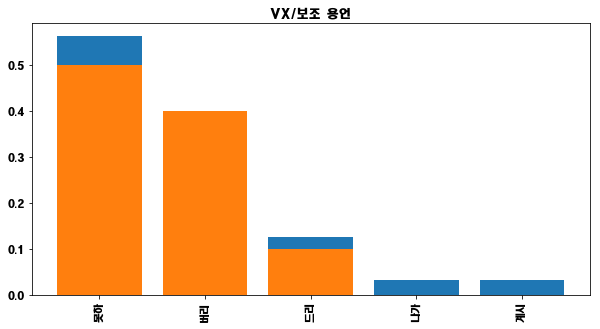

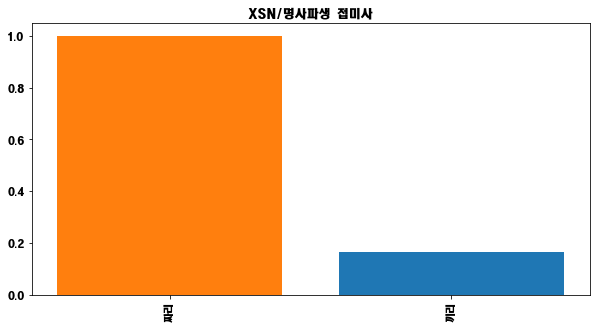

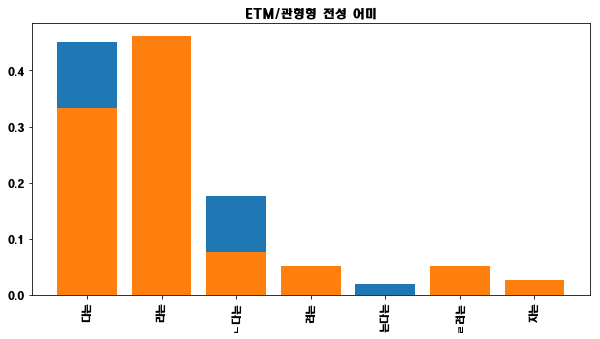

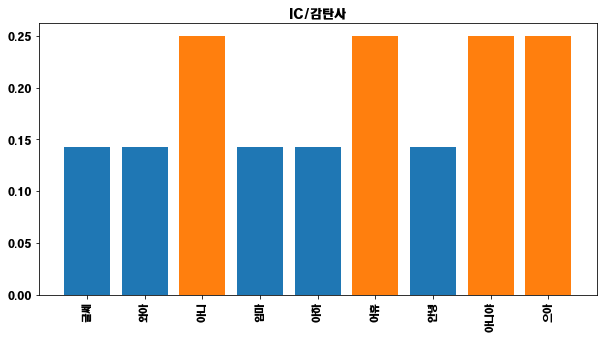

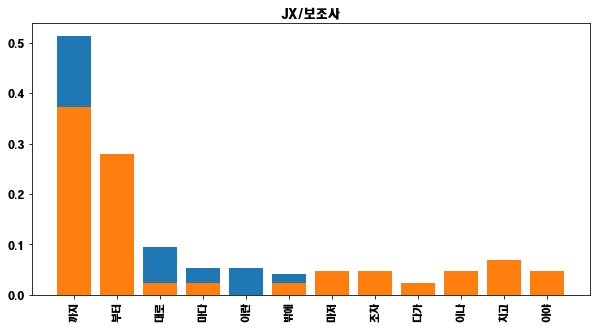

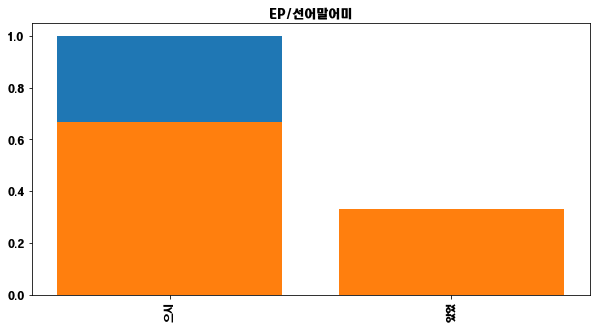

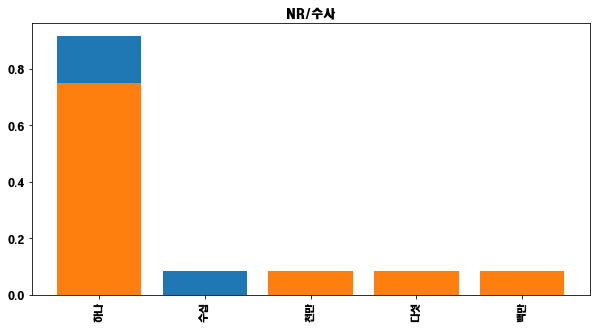

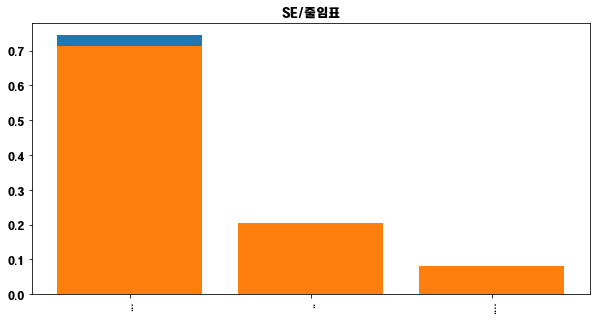

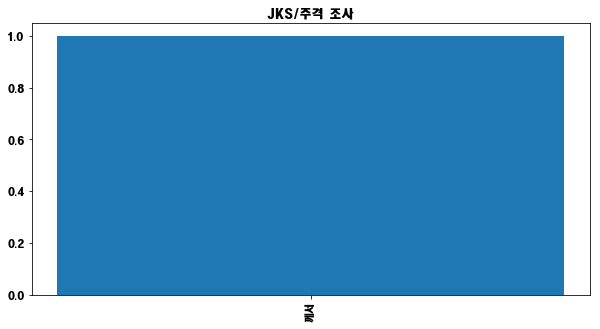

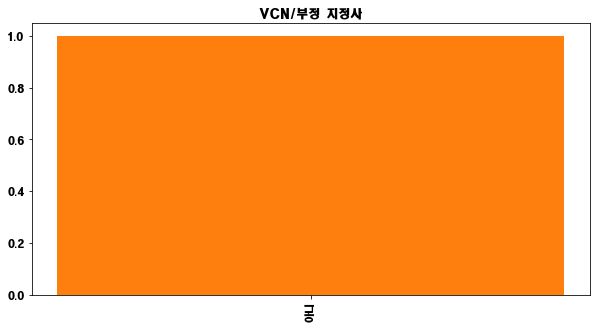

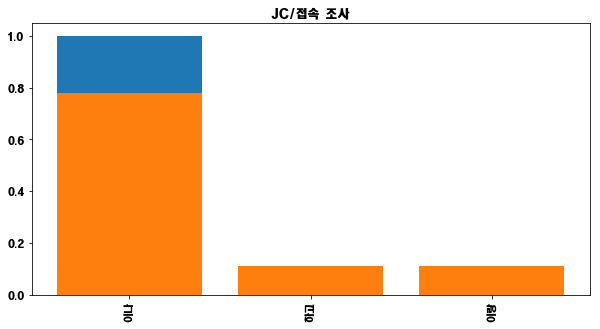

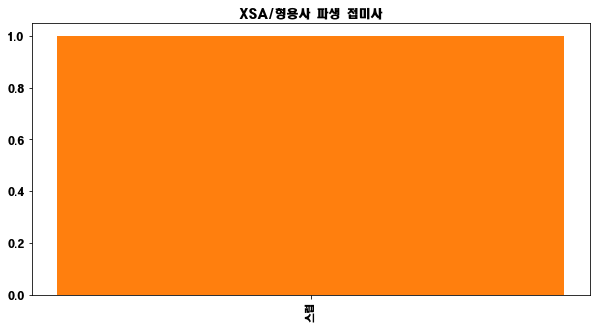

In [70]:
from konlpy.tag import Komoran
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt

tagList = Komoran().tagset

path = "C:/windows/fonts/HMKMRHD.ttf"

family = font_manager.FontProperties(fname=path).get_name()
rc("font", family=family)
rc("figure", figsize=(10,5))

for posName in positivePOS.keys():
    pNorm = sum(positivePOS[posName].values())
    pTermList = [pair[0] for pair in positivePOS[posName].most_common()[:20]]
    pFreqList = [pair[1]/pNorm for pair in positivePOS[posName].most_common()[:20]]
    
    nNorm = sum(negativePOS[posName].values())
    nTermList = [pair[0] for pair in negativePOS[posName].most_common()[:20]]
    nFreqList = [pair[1]/nNorm for pair in negativePOS[posName].most_common()[:20]]
    
    plt.title("{0}/{1}".format(posName, tagList[posName]))
    plt.bar(pTermList, pFreqList, align="center")
    plt.bar(nTermList, nFreqList, align="center")
    plt.xticks(rotation=90)
    plt.show()

In [71]:
# PMI 돌리기 -> 두 확률변수의 elements에 대해 상관성을 측정하는 방법
# PMI(x, y)

from math import log

K = 0.1
N = len(positiveDTM) + len(negativeDTM)

positivePMI = defaultdict(float)
positiveNPMI = defaultdict(float)

seedDocList = list(positiveDTM.keys()) # positive 개수
seedLikelihood = len(seedDocList)/N

for term in list(set(positiveLexicon + negativeLexicon)): # positiveLexicon + negativeLexicon는 전체 단어인 셈
    #DF가 몇인지(단어가 몇번 나왔는지)
    termDocList = list(positiveTDM[term].keys()) + list(negativeTDM[term].keys()) # DF에 해당하는 값을 키값으로 가져온 문서들을 합쳤으므로 전체 문서가 된다. 
    termLikelihood = len(termDocList)/N # 수식의 x/N 부분

    jointLikelihood = (len(positiveTDM[term].keys()) + K)/N # Positive 중 term이라는 단어가 나온 문서의 개수 (수식의 분자 부분)
    multiLikelihood = seedLikelihood * termLikelihood

    positivePMI[term] = log(jointLikelihood/multiLikelihood) # 음/양의 상관 관계 파악 목적. -무한대부터 -min값 사이를 가짐. (빈도가 한번밖에 안나오는 경우 -무한대값이 대단히 커지는 문제 발생.)
    positiveNPMI[term] = positivePMI[term]/-log(jointLikelihood) # 바로 윗줄의 문제를 피하기 위해 -1~1로 정규화

In [72]:
# positive계산할때와 비슷하게 계산
negativePMI = defaultdict(float)
negativeNPMI = defaultdict(float)

seedDocList = list(negativeDTM.keys())
seedLikelihood = len(seedDocList)/N

for term in list(set(positiveLexicon + negativeLexicon)):
    termDocList = list(positiveTDM[term].keys()) + list(negativeTDM[term].keys())
    termLikelihood = (len(termDocList) + K)/N

    jointLikelihood = (len(negativeTDM[term].keys()) + K)/N
    multiLikelihood = seedLikelihood * termLikelihood

    negativePMI[term] = log(jointLikelihood/multiLikelihood)
    negativeNPMI[term] = negativePMI[term]/-log(jointLikelihood)

In [73]:
pmiSO = defaultdict(float)
invertedPmiSO = defaultdict(float)

npmiSO = defaultdict(float)
invertedNpmiSO = defaultdict(float)

for term in list(set(positiveLexicon + negativeLexicon)):
    pmiSO[term.split("/")[0]] += positivePMI[term] - negativePMI[term]
    invertedPmiSO[term.split("/")[0]] -= positivePMI[term] - negativePMI[term]
    
    npmiSO[term.split("/")[0]] += positiveNPMI[term] - negativeNPMI[term]
    invertedNpmiSO[term.split("/")[0]] -= positiveNPMI[term] - negativeNPMI[term]

In [74]:
print(sorted(pmiSO.items(), key=lambda x:x[1], reverse=True)[:10])

print(sorted(npmiSO.items(), key=lambda x:x[1], reverse=True)[:10])

print(sorted(pmiSO.items(), key=lambda x:x[1], reverse=False)[:10])

print(sorted(npmiSO.items(), key=lambda x:x[1], reverse=False)[:10])

[('약간', 7.965225548108711), ('정리', 7.639989296095944), ('엄마', 6.9864483567566715), ('아들', 6.79418721014029), ('완벽', 6.679149542107851), ('만족', 6.223906127457361), ('후반', 6.223906127457361), ('대로', 6.0454408643454105), ('끝내', 6.026216608146095), ('장식', 5.923777140425841)]
[('약간', 0.901098244282807), ('정리', 0.863332095816469), ('엄마', 0.7909347220305427), ('아들', 0.7647498299390993), ('완벽', 0.7511611427520533), ('대로', 0.7236750001298684), ('만족', 0.6981349658772646), ('후반', 0.6981349658772646), ('아쉽', 0.6823925201506541), ('끝내', 0.676474671574917)]
[('뇌물', -7.879110887539209), ('사고', -7.591428815087427), ('아야지', -7.591428815087427), ('좌파', -6.898281634527482), ('지도', -6.492816526419318), ('바보', -6.492816526419318), ('구만', -6.492816526419318), ('지식', -6.492816526419318), ('돌리', -6.492816526419318), ('아라', -6.339847181637891)]
[('뇌물', -0.9241170264450428), ('아니', -0.9004511632801533), ('아야지', -0.8930556635383817), ('사고', -0.8868979562763653), ('아라', -0.86626798045507), ('유치', -0.8118186268275

In [75]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

path = "C:/windows/fonts/HMKMRHD.ttf"

def drawCloud(words):
    wc = WordCloud(font_path=path, max_words=30, background_color="white")
    wc.generate_from_frequencies(words)
    plt.imshow(wc.to_array())
    plt.axis("off")
    plt.show()

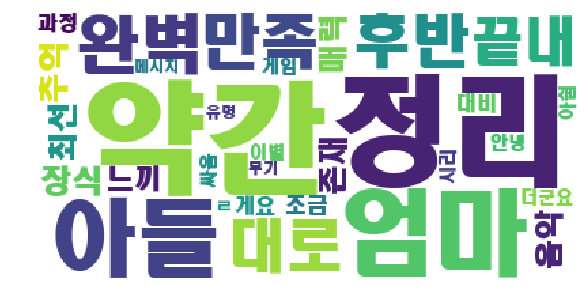

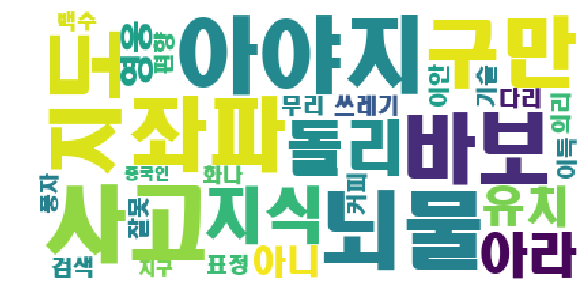

In [76]:
drawCloud(dict(sorted(pmiSO.items(), key=lambda x:x[1], reverse=True)[:30])) # positive
drawCloud(dict(sorted(invertedPmiSO.items(), key=lambda x:x[1], reverse=True)[:30])) # negative

In [87]:
# 새로운 데이터로 돌려보기

# movieReview = "크리스찬 베일의 팬이라 봤는데 연기는 진짜 완벽했다.딕체니만 연구하고 파고든 이유를 충분히 보여줬다.911 이후 우리가 알지 못한 미국의 정치적 이야기가 흥미로웠다.이라크와 아프간 문제를 두고 대립하는 관료들의 설전은 실제로 보는 거처럼 리얼했다."
# movieReview = "영화보고 평점달긴 또 처음이네요...왜 이렇게 눈물이 나는지 모르겠네요ㅠ줄거리보다 마음이 느껴지는 한편의 인생을 보는것 같아요. 강추!!!"
# movieReview = "소리 내 울지 않았던 아버지가 펑펑 우는 그 순간, 영화의 절정이라는 것을 깨달았다. 감동이 휘몰아 치면서 영화에 동화되었다. 하지만 중간에 등장했던 떡밥들이 어중간하게 풀리면서 찜찜함을 남겨주기도 한다."

# movieReview = "말이 필요 없네요 기다린 만큼 재미나게 보고 왔습니다"
# movieReview = "초중반은 지루하고 마지막이 그나마 볼만함마블다른영화보다는 구성이 탄탄하지 않음"
movieReview = "영화라고하기엔;;드라마 스페셜 수준"
# movieReview = "왜 하필 이런 3류영화는 영화 소개부터 꼴통형사로 시작하냐 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ"
# movieReview = "ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 진짜 제목부터 보고싶지않은 영화는 처음이닼ㅋㅋㅋ"

posList = ma.pos(movieReview)
reviewTerms = list()
    
for term in posList:
    if len(term[0]) > 1:
        reviewTerms.append(term[0])

In [88]:
pmiScore = 0.0
npmiScore = 0.0

for term in reviewTerms:
    pmiScore += pmiSO[term]
    npmiScore += npmiSO[term]
    print(term, pmiSO[term], npmiSO[term])
    
if npmiScore > 0.1:
    print("Positive")
elif npmiScore < -0.1:
    print("Negative")
else:
    print("Neutral")

print(pmiScore, npmiScore)

영화 -1.0750886197026484 -0.3593537707353285
라고 -3.649150486809015 -0.4866028085297771
드라마 스페셜 -2.8998346729296864 -0.3328991516276321
수준 -2.421279922694701 -0.4126794724397692
Negative
-10.045353702136051 -1.5915352033325068


In [89]:
pSeed = (['재밌', '슬프'])
pSeed2 = (["재미없", '지겹'])

In [90]:
globalDTM = defaultdict(Counter)

for i, review in enumerate(data["review"]):
    posList = ma.morphs(review)
    
    for term in posList:
        if len(term) >1:
            globalDTM[i][term] += 1

KeyError: 'review'

In [93]:
globalTDM = defaultdict(Counter)

for i, termList in globalDTM.items():
    for term, freq in termList.items():
        globalTDM[term][i]= freq        

In [94]:
globalLexicon = list(globalTDM.keys())

In [86]:
# 의미를 보려고 하는 것이 아니라 단어 간의 관계를 보고자 하므로 영어 한글 혼용해도 잘 작동. 
# 학습 데이터에 seed 단어가 없다면 빈도가 0이므로 결과가 나오지 않는다. 따라서 seed에 맞게 데이터셋(몇백만 건 이상)을 구축해야 함.
# 이부분부터 html보고 수정(4/24)

pSeed = ["예쁘"] 
nSeed = ["지겹"]

from math import log

K = 0.1
N = len(positiveDTM) + len(negativeDTM)

pGlobalPMI = defaultdict(float)
pGlobalNPMI = defaultdict(float)

seedDocList = list(globalTDM[pSeed[0]].keys())
seedLikelihood = len(seedDocList)/N

for term in globalLexicon:
    termDocList = list(positiveTDM[term].keys()) + list(negativeTDM[term].keys())
    termLikelihood = len(termDocList)/N

    jointLikelihood = (lenset((seedDocList).intersection(termDocList) + K)/N
    multiLikelihood = seedLikelihood * termLikelihood

    positivePMI[term] = log(jointLikelihood/multiLikelihood)
    positiveNPMI[term] = pGlobalPMI[term]/-log(jointLikelihood)

SyntaxError: invalid syntax (<ipython-input-86-2481bbe96c83>, line 20)

In [ ]:
nGlobalPMI = defaultdict(float)
nGlobalNPMI = defaultdict(float)

seedDocList = list(globalTDM[pSeed[0]].keys())
seedLikelihood = len(seedDocList)/N

for term in list(set(positiveLexicon + negativeLexicon)):
    termDocList = list(positiveTDM[term].keys()) + list(negativeTDM[term].keys())
    termLikelihood = (len(termDocList) + K)/N

    jointLikelihood = (len(negativeTDM[term].keys()) + K)/N
    multiLikelihood = seedLikelihood * termLikelihood

    negativePMI[term] = log(jointLikelihood/multiLikelihood)
    negativeNPMI[term] = negativePMI[term]/-log(jointLikelihood)

### 명사만으로 감정 분석해보기

In [97]:
pSeed = (['재밌', '슬프', '감동'])
pSeed2 = (["재미없", '지겹'])

In [98]:
globalTDM = defaultdict(Counter)

for i, review in enumerate(data["review"]):
    posList = ma.morphs(review) # 모든 명사에 대한 목록
    
    for term in posList:
        if len(term) >1:
            globalTDM[i][term] += 1
            # term=> i번째 문서 = 1. 즉 어떤 단어 term이 i번째 문서에서 나왔다는 의미
            # term df => term {문서:1, 문서:1, 문서:1}

KeyError: 'review'

In [99]:
globalLexicon = globalTDM.keys()

In [96]:
K = 0.1
N = len(data["review"])

pNounPMI = defaultdict(float)
pNounNPMI = defaultdict(float)
# 어떤 단어가 어떤 명사에 대해 상관성이 +인지 -인지 

seedDocList = list(globalTDM['감동'].keys())
seedLikelihood = len(seedDocList)/N

for term in globalLexicon:
    termDocList = list(globalTDM[term].keys()) + list(negativeTDM[term].keys())
    termLikelihood = len(termDocList)/N

    jointLikelihood = (len(set(seedDocList).intersection(termDocList)) + K)/N # intersection이 0이 되는 것을 막기 위해 K를 더해줌
    multiLikelihood = seedLikelihood * termLikelihood

    pNounPMI[term] = log(jointLikelihood/multiLikelihood)
    pNounNPMI[term] = pGlobalPMI[term]/-log(jointLikelihood)

KeyError: 'review'

In [ ]:
K = 0.1
N = len(data["review"])

nNounPMI = defaultdict(float)
nNounNPMI = defaultdict(float)
# 어떤 단어가 어떤 명사에 대해 상관성이 +인지 -인지 

seedDocList = list(globalTDM['최악'].keys())
seedLikelihood = len(seedDocList)/N

for term in globalLexicon:
    termDocList = list(globalTDM[term].keys()) + list(negativeTDM[term].keys())
    termLikelihood = len(termDocList)/N

    jointLikelihood = (len(set(seedDocList).intersection(termDocList)) + K)/N # intersection이 0이 되는 것을 막기 위해 K를 더해줌
    multiLikelihood = seedLikelihood * termLikelihood

    nNounPMI[term] = log(jointLikelihood/multiLikelihood)
    nNounNPMI[term] = nNounPMI[term]/-log(jointLikelihood)

In [ ]:
globalSO = defaultdict(float)
globalInvertedSO = defaultdict(float)

globalNSO = defaultdict(float)
globalInvertedNSO = defaultdict(float)

for term in globalTDM.keys():
    globalSO[term] += pNounPMI[term] - nNounPMI[term]
    globalInvertedSO[term] -= pNounPMI[term] - nNounPMI[term]
    
    globalNSO[term] += pNounNPMI[term] - nNounNPMI[term]
    globalInvertedNSO -= pNounNPMI[term] - nNounNPMI[term]